Identifying what's true and what's not is getting harder these days. While machines can create a lot of fake information, they can also help us tell the difference between real and fake—at least to some extent. So, in this tutorial, let's try building some basic neural network models to spot fake news.

## Acquiring the Data

As always, let's start by importing the necessary libraries:

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import keras
from keras import layers, losses
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
pio.renderers.default="iframe"

Now, let's get and load the training data:

In [2]:
train_url = "https://raw.githubusercontent.com/pic16b-ucla/25W/refs/heads/main/datasets/fake_news_train.csv"

# Load the data
df = pd.read_csv(train_url)
df.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


As you can see, each row represents an article. We should pay attention to the `title`, `text`, and `fake` columns. For the final column, `0` refers to a true article, while `1` indicates that the artricle contains fake news.

## Preparing the Data

We'll prepare our data by creating a TensorFlow `Dataset` with proper text preprocessing. We'll need to handle both the title and text fields.

In [3]:
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

def make_dataset(dataframe, batch_size=100):

    # Remove stopwords
    def nostop(text):
        if isinstance(text, str):
            words = text.lower().split() # Change text to lowercase
            filtered_words = [word for word in words if word not in stop]
            return " ".join(filtered_words)
        return ""

    # Apply preprocessing
    df_processed = dataframe.copy()
    df_processed['title'] = df_processed['title'].apply(nostop)
    df_processed['text'] = df_processed['text'].apply(nostop)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            {
                "title": df_processed["title"],
                "text": df_processed["text"]
            },
            df_processed["fake"]
        )
    )

    # Shuffle and batch
    dataset = dataset.shuffle(len(df_processed), reshuffle_each_iteration=False)
    dataset = dataset.batch(batch_size)

    return dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Validation Data

Now, let's split our created dataset into training and validation sets:

In [4]:
# Create dataset
full = make_dataset(df)

# Calculate split sizes
dataset_size = len(df)
train_size = int(0.8 * dataset_size) # 20% for validation
val_size = dataset_size - train_size

# Split the dataset
train = full.take(train_size//100)
val = full.skip(train_size//100)

print(f"Training batches: {len(list(train))}")
print(f"Validation batches: {len(list(val))}")

Training batches: 179
Validation batches: 46


### Base Rate

Before constructing any model, we should calculate our base rate, which is the accuracy we would get if the model always predicted the most common class. We can do this by examining the distribution of the "fake" labels in the training data.

In [5]:
# Calculate base rate
fake_distribution = df['fake'].value_counts(normalize=True)
base_rate = max(fake_distribution)
print(f"Base rate: {base_rate:.4f} ({base_rate*100:.2f}%)")

Base rate: 0.5230 (52.30%)


The base rate of predicting fake news is around 52%. Any model we built should perform significantly better than this base rate ot be considered useful!

### Text Vectorization

Before feeding it into our neural network, we need to standardize and vectorize our text data:

In [6]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                 '[%s]' % re.escape(string.punctuation), '')
    return no_punctuation

# Create vectorization layers
title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

text_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,
    output_mode='int',
    output_sequence_length=500)

# Adapt the vectorization layers to the data
title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))
text_vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

## Building Model

Now, we're ready to construct our models. Let's investigate the following problem:

> When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?

We'll build three models to address this question.

We can first specify the inputs to our models:

In [7]:
title_input = keras.Input(shape=(1,), name="title", dtype="string")
text_input = keras.Input(shape=(1,), name="text", dtype="string")

And we should write a function for training and evaluating the models:

In [8]:
def run(model, train_data, val_data, name, epochs):

    # Create early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f"{name} model: {val_accuracy:.4f}")

    return history

We should also prepare a simple visualization function to plot the training history:

In [9]:
def plot_acc(history, title="Model"):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')

    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Model 1: Title-only

The first model will only involve the **article title** as an input:

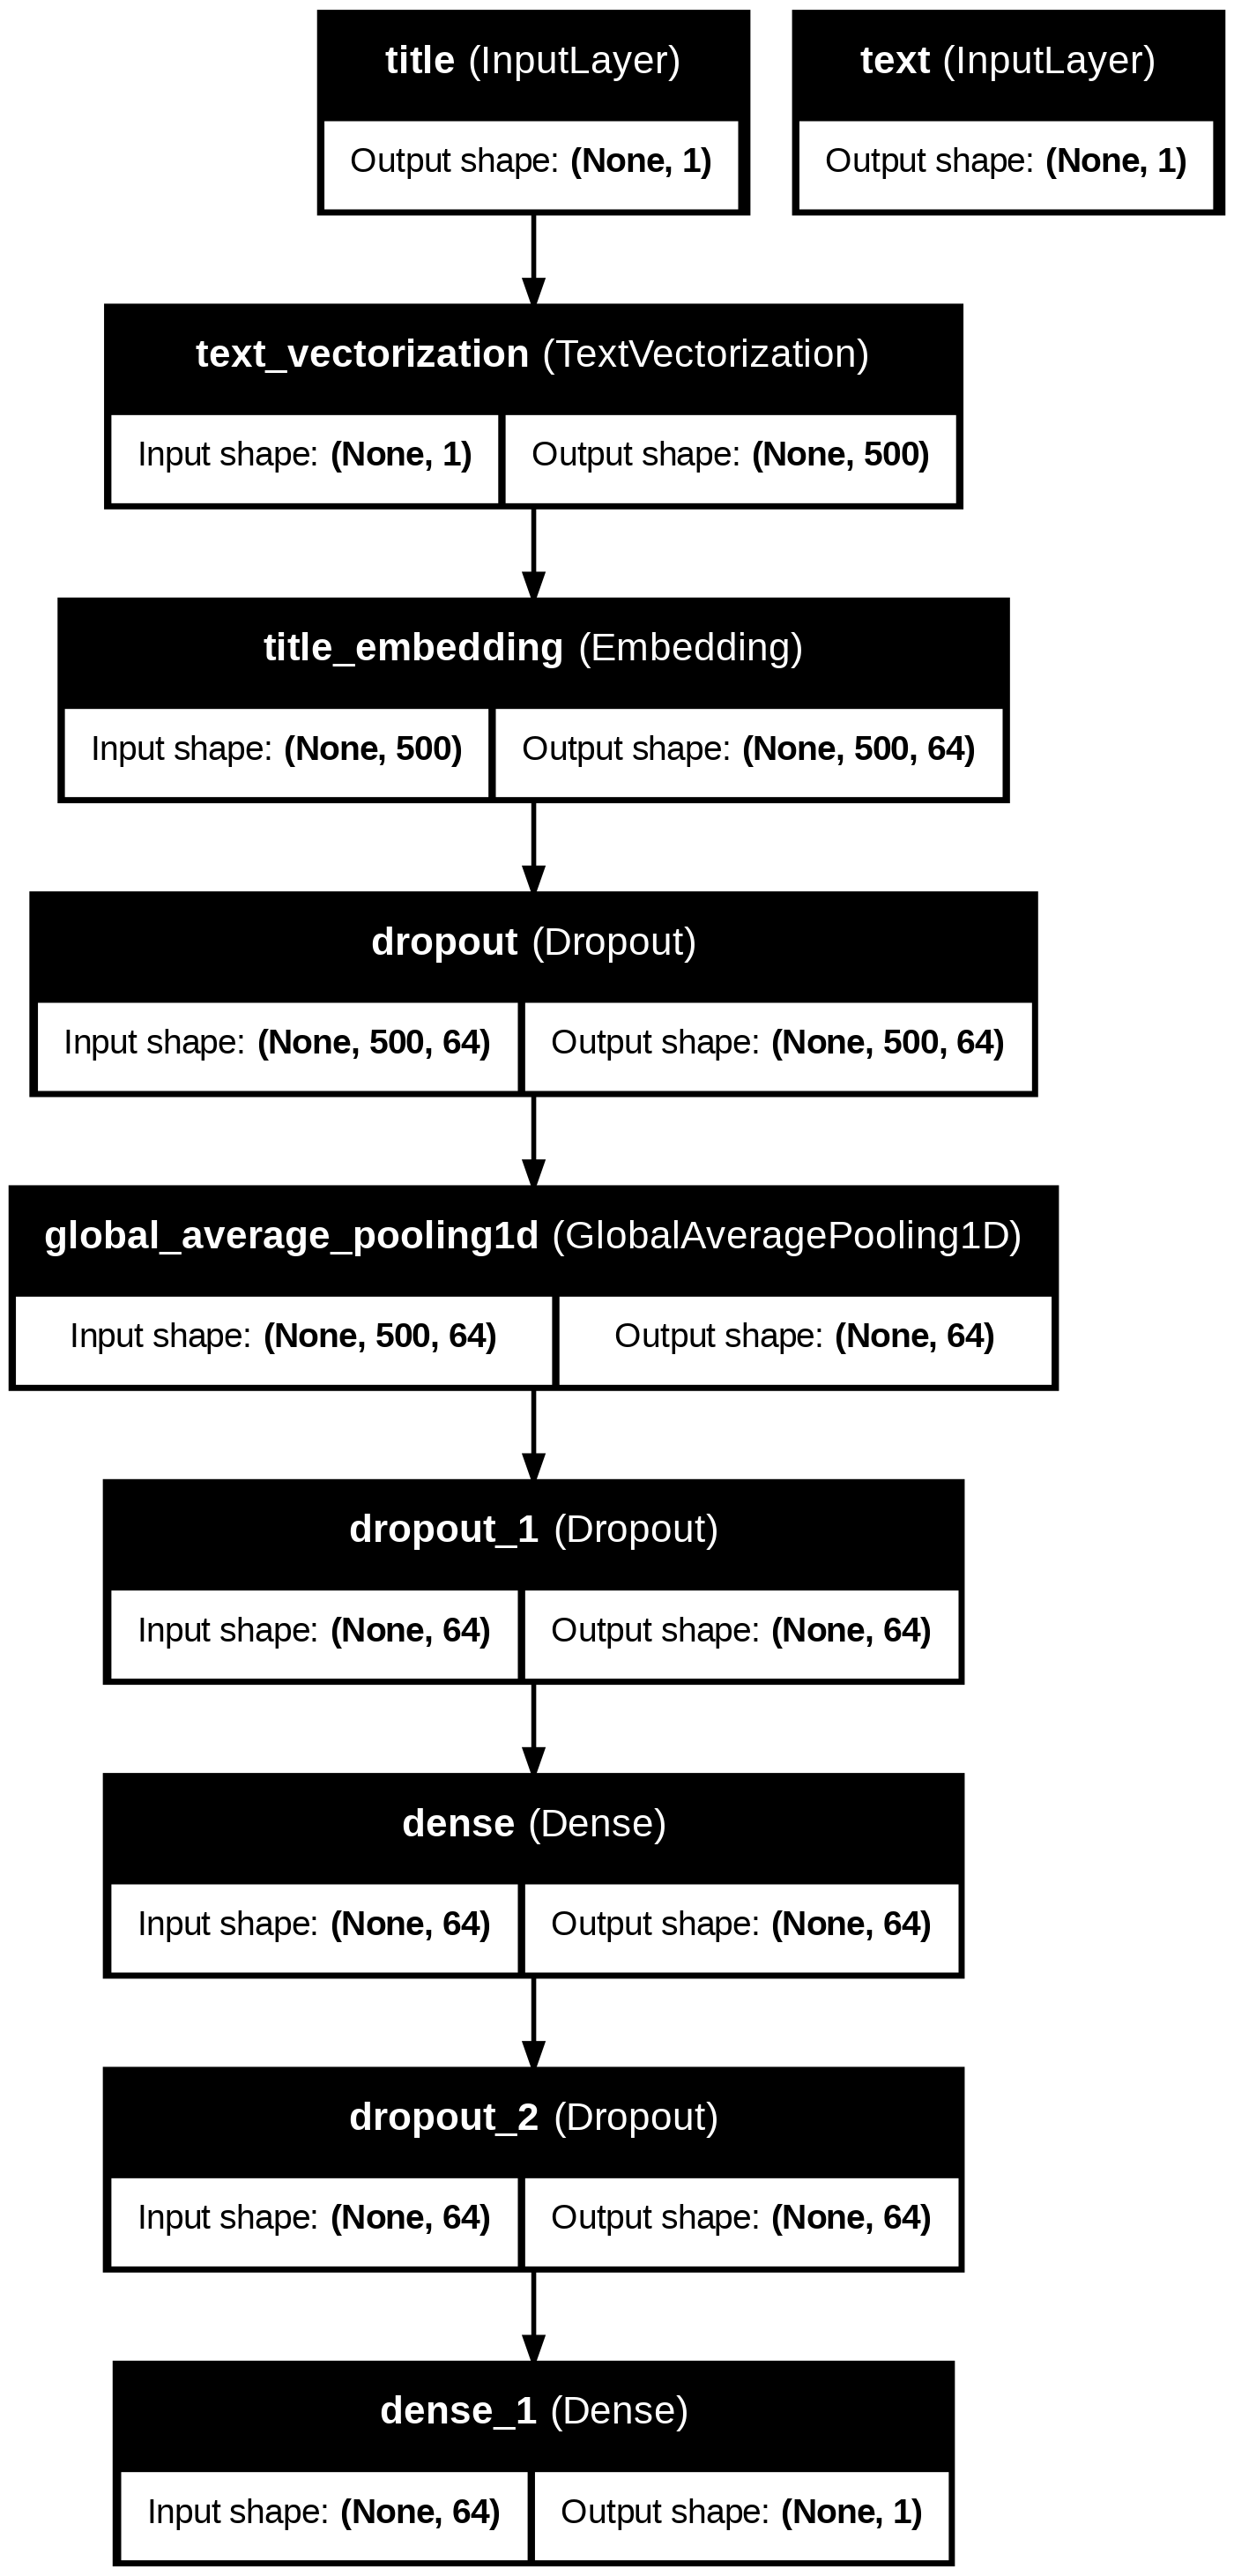

In [10]:
x = title_vectorize_layer(title_input)
x = layers.Embedding(size_vocabulary, output_dim=64, name="title_embedding")(x)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model1 = keras.Model(inputs={"title": title_input, "text": text_input}, outputs=output)
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

from keras.utils import plot_model
plot_model(model1, "title_model.png", show_shapes=True, show_layer_names=True)

Let's train the first model and see how it performs:

In [11]:
history1 = run(model1, train, val, "Title-only", epochs=20)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5164 - loss: 0.6933 - val_accuracy: 0.4834 - val_loss: 0.6926
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5233 - loss: 0.6924 - val_accuracy: 0.4887 - val_loss: 0.6915
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5324 - loss: 0.6900 - val_accuracy: 0.7624 - val_loss: 0.6845
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5683 - loss: 0.6818 - val_accuracy: 0.6621 - val_loss: 0.6464
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6217 - loss: 0.6471 - val_accuracy: 0.6795 - val_loss: 0.5705
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7021 - loss: 0.5695 - val_accuracy: 0.6579 - val_loss: 0.5823
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7300 - loss: 0.5217 - val_accuracy: 0.6428 - val_loss: 0.6160
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7605 - loss: 0.4853 - val_accuracy:

And let's visualize our training and validation accuracy of training the first model:

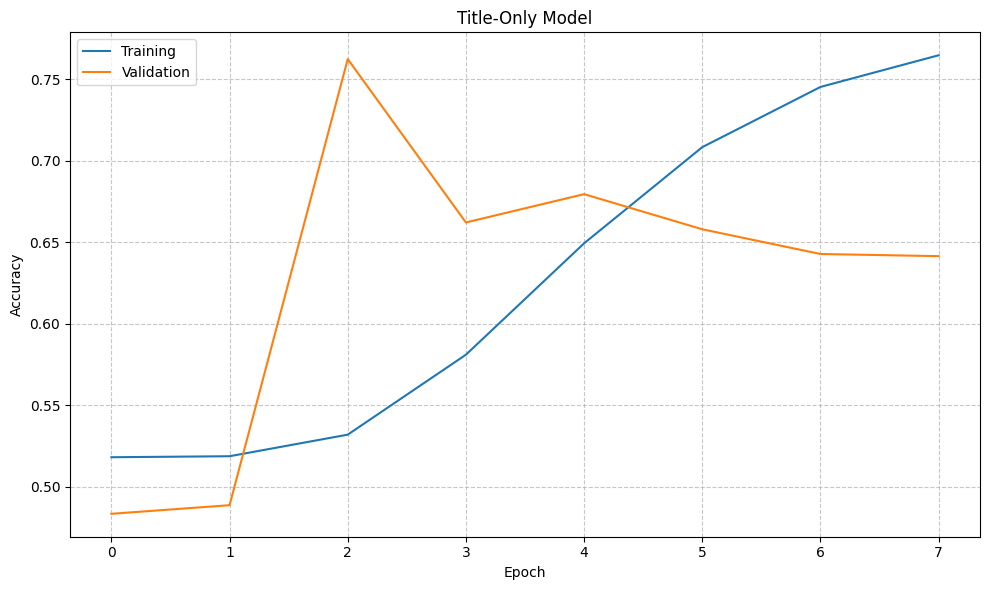

In [12]:
plot_acc(history1, "Title-Only Model")

The first model stabilized around 68% accuracy on the validation set. This is not bad, as it is significantly higher than the base rate.

### Model 2: Text-only

Then, let's try the second model, which will have only the **article text** as input.

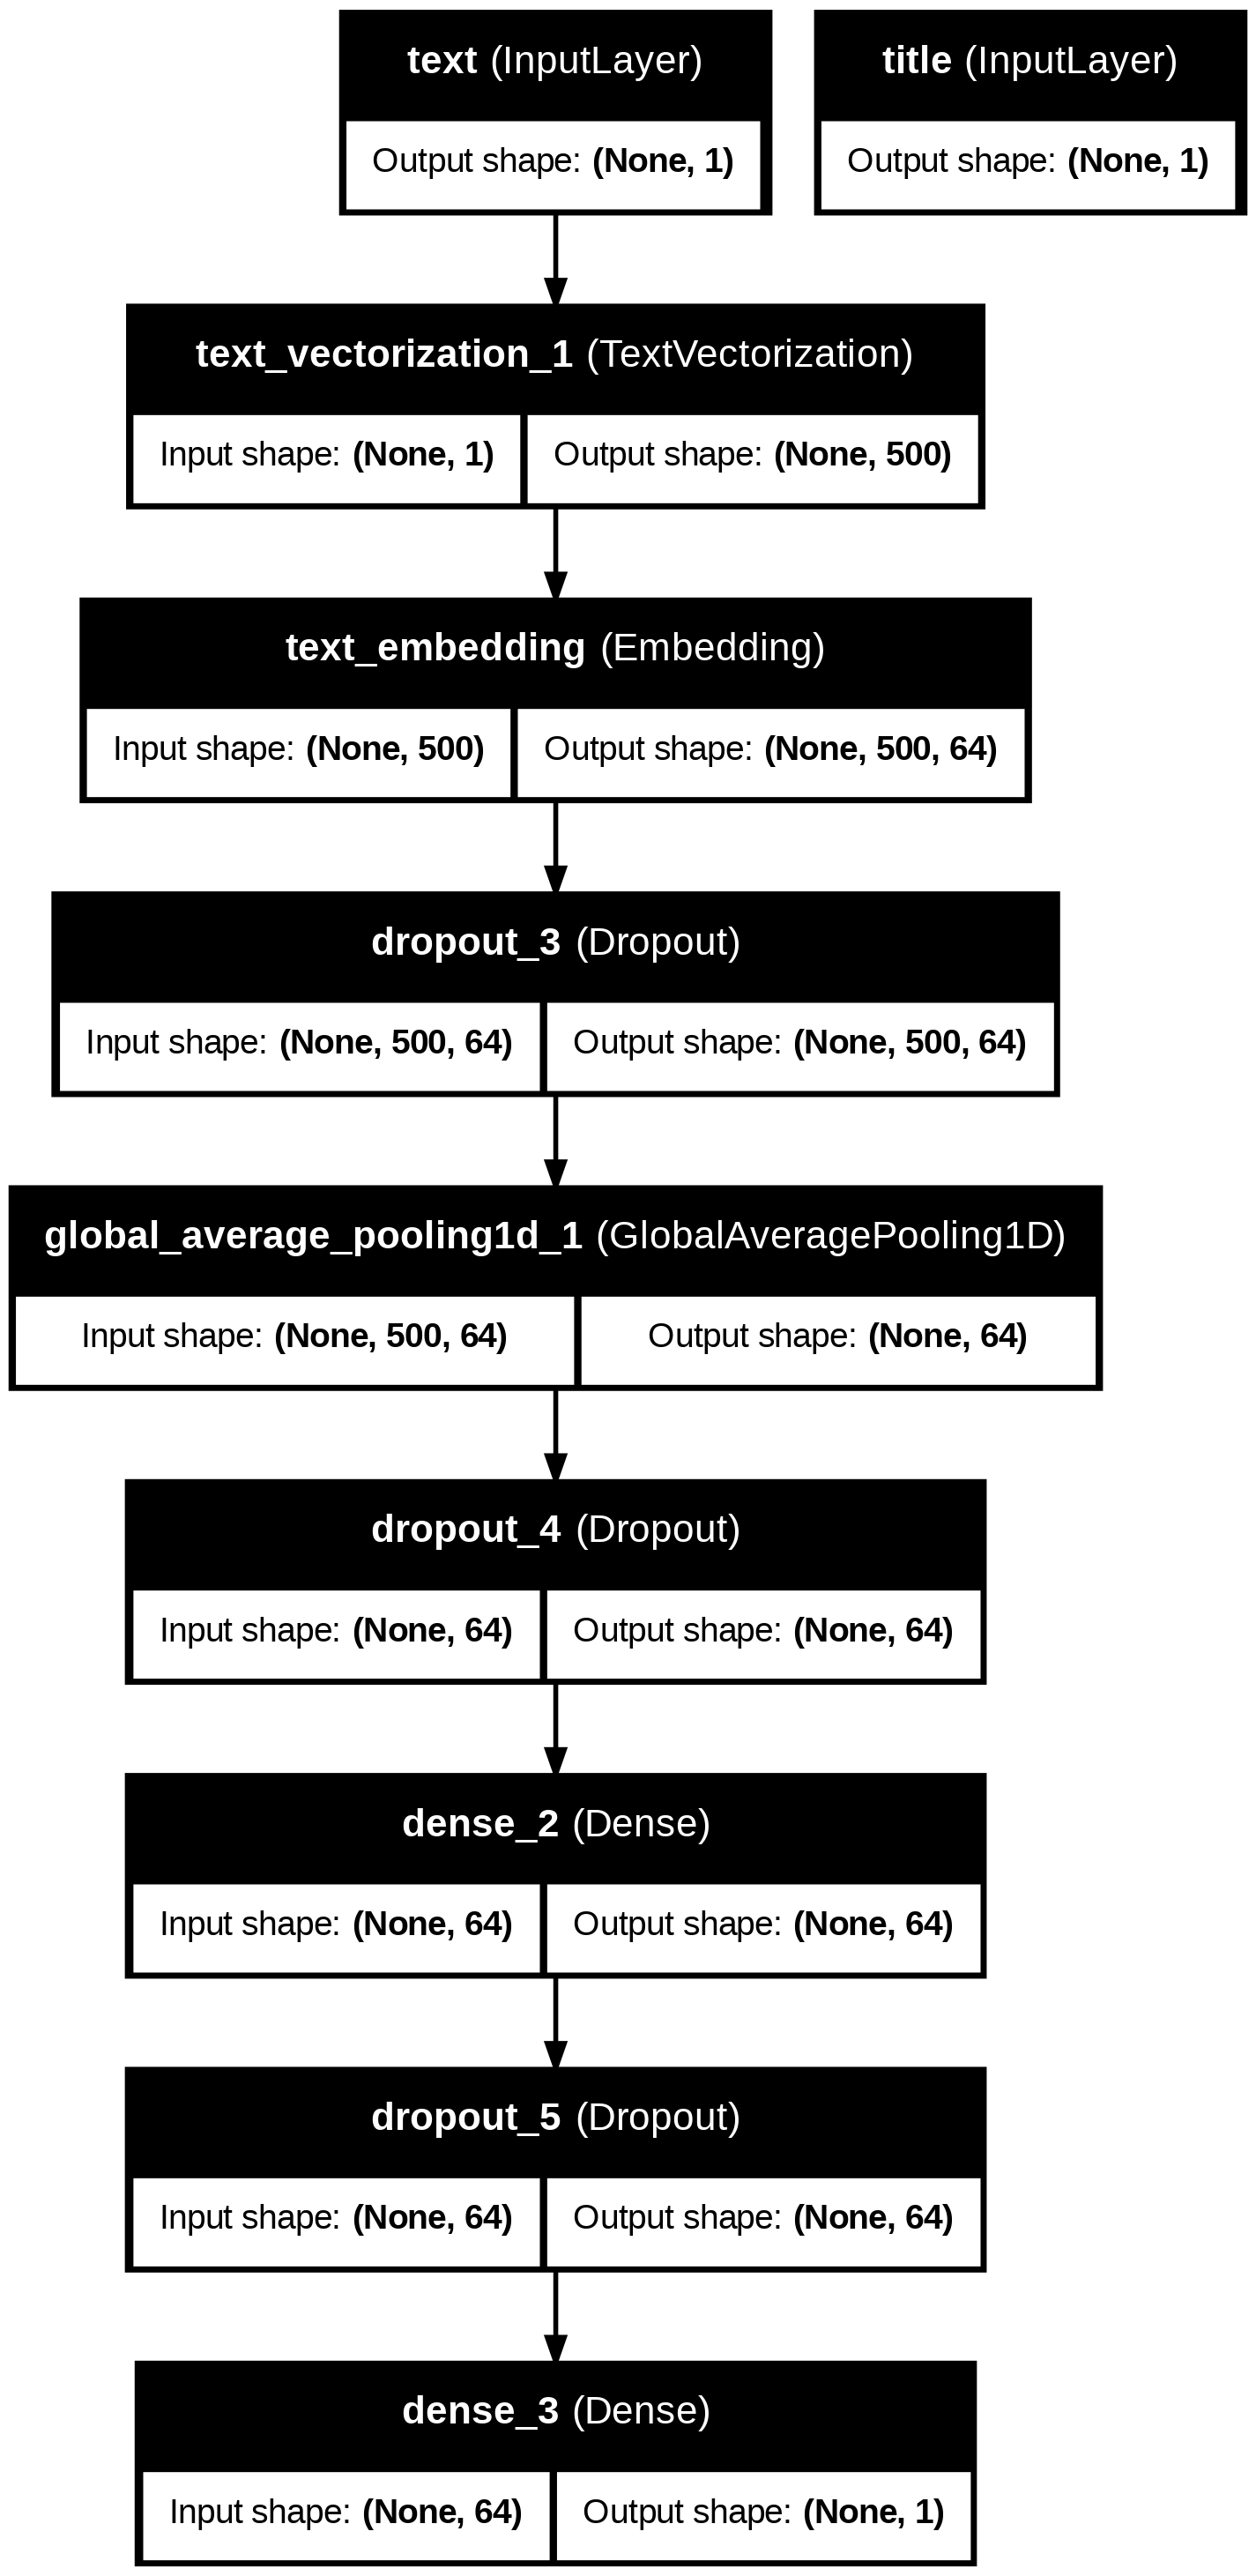

In [13]:
x = text_vectorize_layer(text_input)
x = layers.Embedding(size_vocabulary, output_dim=64, name="text_embedding")(x)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model2 = keras.Model(inputs={"title": title_input, "text": text_input}, outputs=output)
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
plot_model(model2, "text_model.png", show_shapes=True, show_layer_names=True)

Now, let's train the second model and see how it competes with the first model:

In [14]:
history2 = run(model2, train, val, "Text-only", epochs=20)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6140 - loss: 0.6398 - val_accuracy: 0.8116 - val_loss: 0.3439
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9072 - loss: 0.2419 - val_accuracy: 0.9365 - val_loss: 0.1788
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9409 - loss: 0.1598 - val_accuracy: 0.9591 - val_loss: 0.1377
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9573 - loss: 0.1237 - val_accuracy: 0.9657 - val_loss: 0.1177
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9609 - loss: 0.1101 - val_accuracy: 0.9714 - val_loss: 0.1023
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9647 - loss: 0.1006 - val_accuracy: 0.9670 - val_loss: 0.1008
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9681 - loss: 0.0898 - val_accuracy: 0.9703 - val_loss: 0.0918
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9713 - loss: 0.0809 - val_accu

And we can visualize the training history of the second model:

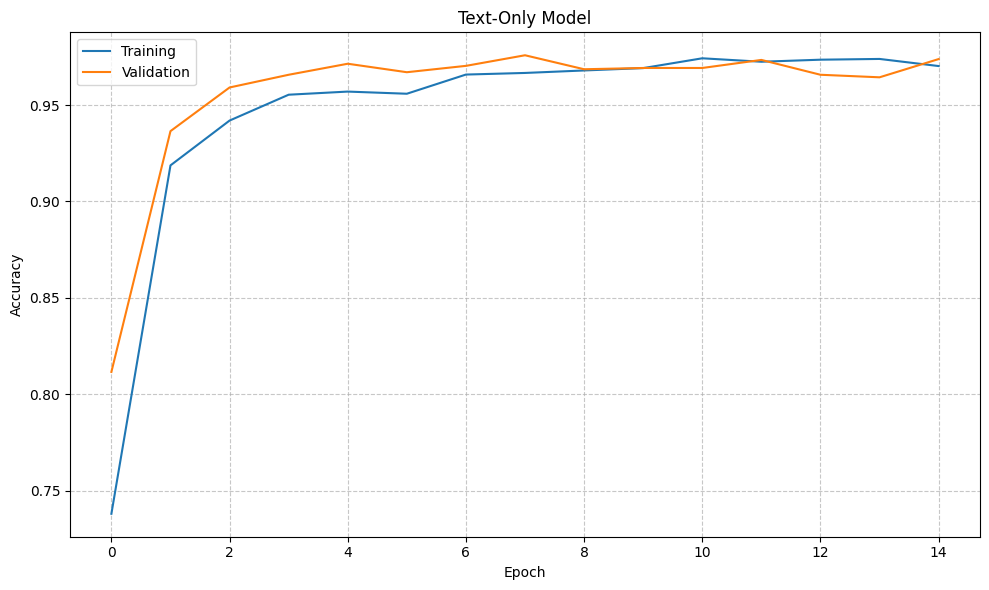

In [15]:
plot_acc(history2, "Text-Only Model")

This is an impressive improvement from the first model: the model scores around 97% on the validation data. There's also hardly any sign of overfitting. From this, we can infer that it is more effective to use full text of article than to use title of the article to predict fake news.

### Model 3: Combined (Title and text)

For the third model, we will use both the **article title and article text** as input.

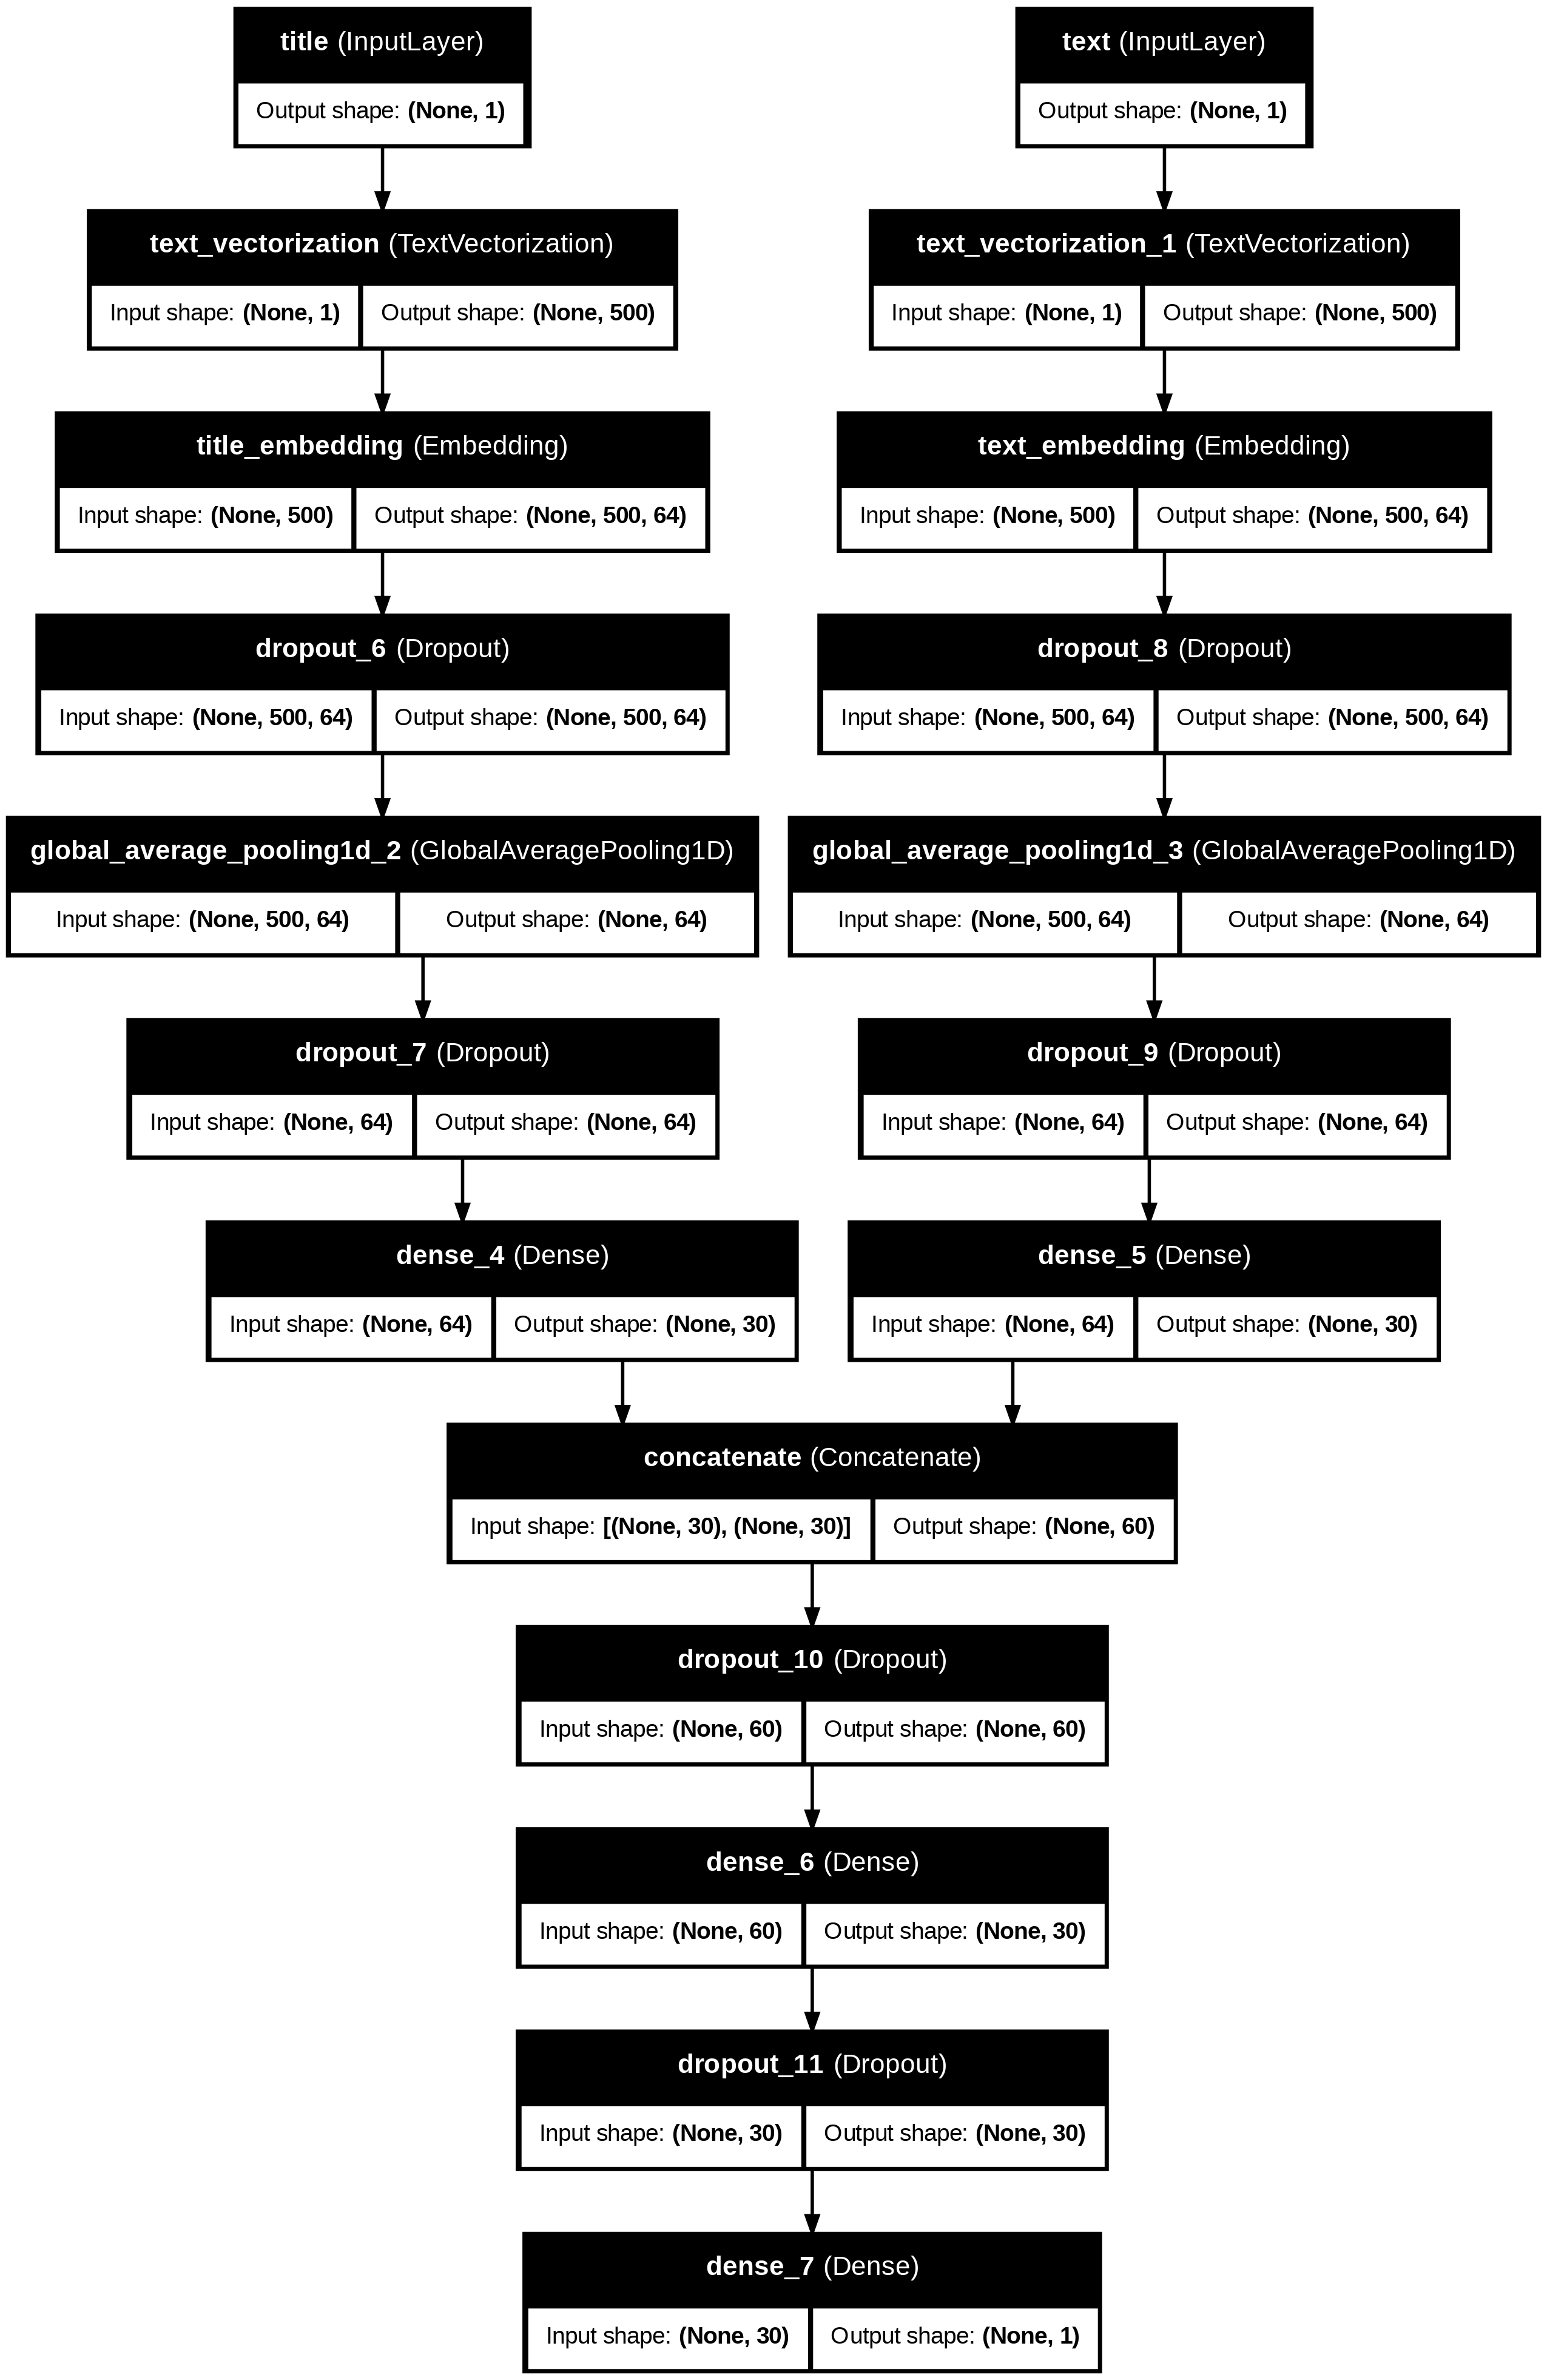

In [16]:
# Title branch
t = title_vectorize_layer(title_input)
t = layers.Embedding(size_vocabulary, output_dim=64, name="title_embedding")(t)
t = layers.Dropout(0.2)(t)
t = layers.GlobalAveragePooling1D()(t)
t = layers.Dropout(0.2)(t)
t = layers.Dense(30, activation="relu")(t)

# Text branch
x = text_vectorize_layer(text_input)
x = layers.Embedding(size_vocabulary, output_dim=64, name="text_embedding")(x)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(30, activation="relu")(x)

# Combine branches
combined = layers.concatenate([t, x])
x = layers.Dropout(0.2)(combined)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model3 = keras.Model(inputs={"title": title_input, "text": text_input}, outputs=output)
model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
plot_model(model3, "combined_model.png", show_shapes=True, show_layer_names=True)

Then let's trian this model:

In [17]:
history3 = run(model3, train, val, "Combined", epochs=20)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5844 - loss: 0.6541 - val_accuracy: 0.8929 - val_loss: 0.2492
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8966 - loss: 0.2524 - val_accuracy: 0.9549 - val_loss: 0.1556
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9439 - loss: 0.1556 - val_accuracy: 0.9563 - val_loss: 0.1306
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9528 - loss: 0.1265 - val_accuracy: 0.9279 - val_loss: 0.1683
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9574 - loss: 0.1168 - val_accuracy: 0.9611 - val_loss: 0.1102
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9663 - loss: 0.0974 - val_accuracy: 0.9736 - val_loss: 0.0914
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9621 - loss: 0.1058 - val_accuracy: 0.9692 - val_loss: 0.0900
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9680 - loss: 0.0921 - val_acc

Finally, let's visualize the training history of the third model:

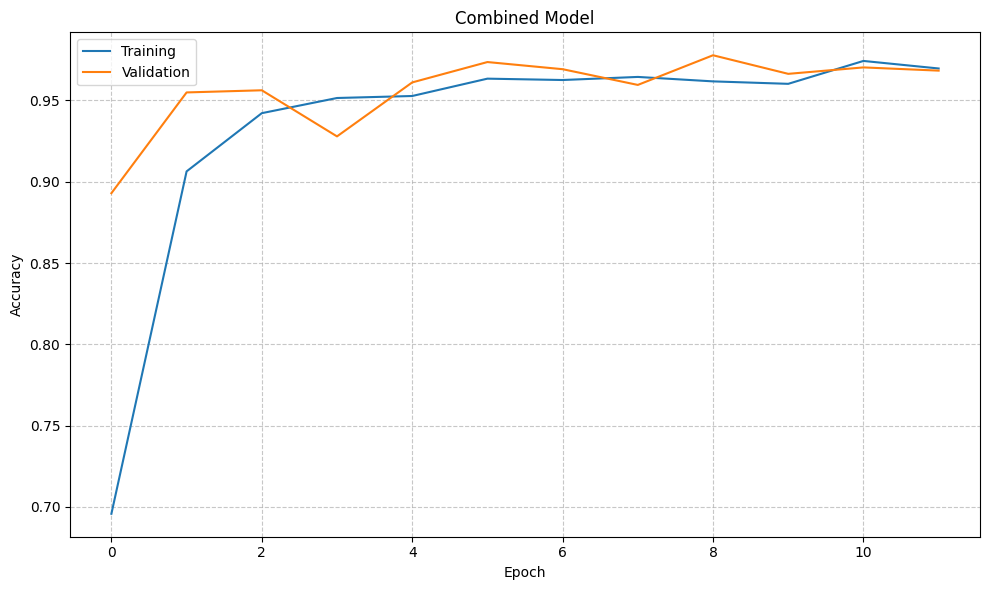

In [18]:
plot_acc(history3, "Combined Model")

This model is almost as good as the last one but slightly better and more performent overall. Using both the title and text to predict fake news also seems very effective. Let's go with this model for testing on the test data.

## Evaluating Model

We'll use the third model to test our model performance on unseen test data.

In [19]:
# Load test data
test_url = "https://raw.githubusercontent.com/pic16b-ucla/25W/refs/heads/main/datasets/fake_news_test.csv"
test_df = pd.read_csv(test_url)

# Create test dataset
test_dataset = make_dataset(test_df)

best_model = model3

# Evaluate on test data
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9744 - loss: 0.0868
Test accuracy: 0.9744


Awesome! We scored 97.4% on the test data. As a result, it is fair to say that a combination of title and full text of the article is a reliable apporach for detecting fake news.

## Embedding Visualization

Let's analyze the word embeddings learned by our model to see what patterns it discovered:

In [24]:
# Get embedding weights and vocabulary
weights = model3.get_layer("text_embedding").get_weights()[0]
vocab = text_vectorize_layer.get_vocabulary()

# Reduce dimensions with PCA
from sklearn.decomposition import PCA
reduced_weights = PCA(n_components=2).fit_transform(weights)

# Create dataframe and plot
df = pd.DataFrame({'word': vocab, 'x': reduced_weights[:, 0], 'y': reduced_weights[:, 1]})
df = df[~df['word'].isin(['', '[UNK]'])] # Filter special tokens

fig = px.scatter(df, x='x', y='y', hover_name='word', title='Learned Word Embedding')
fig.update_layout(xaxis_title="x0", yaxis_title="x1")
fig.show()

The embedding locations reveal interesting patterns in how these politically charged words relate in news contexts:

* "**america**" and "**isis**" are positioned extremely close to each other (x=-5.45/-5.35, y≈-0.15). The model has learned they frequently appear in similar contexts - likely national security and terrorism topics.
* "**american**" is also clustered nearby but slightly closer to the origin, showing it shares semantic context with "**america**".
* "**republicans**" (x=-0.95, y=1.05) appears in an entirely different region than the national security cluster, indicating distinct contextual usage - likely in domestic political reporting rather than international security contexts.
* "**china**" (x=4.07, y=-1.00) is positioned far from both the America/ISIS cluster and "**republicans**," suggesting the model sees it as semantically distinct from both U.S. domestic politics and terrorism topics.